# Feature Extraction

This code contains some of the data exploration done during feature extraction, as well as the features themselves. At the beginning of each section, there is a list of the features that will be used in the final model, as well as any processing steps that were to be applied to it. 

At the very end, we run some basic evaluation steps on the data. 

In [1]:
# installing 1.0.3 because this version of pandas supports write to s3
!pip install pandas==1.0.3

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import os
import re
import pickle
import time
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
teamname = 'emotional-support-vector-machine-unsw'
data_folder='s3://tf-trachack-data/212/'
root_folder='s3://tf-trachack-notebooks/'+teamname+'/jupyter/jovyan/'

In [4]:
def cache(obj, filepath):
    """Cache the result"""
    directory = os.path.dirname(filepath)
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    with open(filepath, 'wb+') as f:
        pickle.dump(obj, f)

def is_cached(filepath):
    """Checks if the pickle file exists"""
    return os.path.isfile(filepath)


def load_cache(filepath):
    """Load the cached result"""
    assert is_cached(filepath)
    
    with open(filepath, 'rb') as f:
        return pickle.load(f)

## 1. Upgrades

- `date_observed`
    - need to make sure we only use data before this date

In [5]:
upgrades=pd.read_csv(data_folder+"data/dev/upgrades.csv")
upgrades

,line_id,date_observed,upgrade
0,f0b99d3b-32f7-4464-8fa8-87f27c9810a8,2021-03-14,yes
1,a2ec0baf-1720-4b1b-bfa3-db00ac8fcb00,2021-03-10,yes
2,dd3a01a3-7baf-4605-9799-ce434328a20d,2021-03-10,no
3,5cf5917c-f407-4cc7-9d6d-dafe8ec0eccc,2021-03-13,no
4,6437fcbd-02c4-4c52-b5b2-f7e535ecec47,2021-03-10,yes
...,...,...,...
55863,f89b108a-f453-4419-a4dc-5bf8e1cd1f1a,2021-03-11,no
55864,b703f1d4-57ba-48b6-8adf-46d7aba6a406,2021-03-13,no
55865,e3b2212c-906e-4a8f-8307-6b88fc64d7a0,2021-03-11,no
55866,828df9bf-279c-47c3-96c2-92177a50b8fd,2021-03-14,no


In [6]:
upgrades['upgrade'].value_counts()

no     40694
yes    15174
Name: upgrade, dtype: int64

In [7]:
NUM_CUSTOMERS = len(upgrades)

In [8]:
def extract1(upgrades, filepath=None, overwrite=False):
    upgrades = upgrades.drop('date_observed', axis=1)
    df1 = upgrades.replace({'no':0,'yes':1})
    return df1

df1 = extract1(upgrades)
df1.head(2)

,line_id,upgrade
0,f0b99d3b-32f7-4464-8fa8-87f27c9810a8,1
1,a2ec0baf-1720-4b1b-bfa3-db00ac8fcb00,1


## 2. Customer Info

- `carrier`
    - one hot encode, only three carriers
- `first_activation_date`
    - compute `years passed`, `months passed`, `log of years passed`, `log of months passed`
- `plan_name`
    - can be either plan 1 - 4, or other
    - one hot encode
- `plan_subtype`
    - Basically all of these are NULL or NAN. Just drop this column.
- `redemption_date`
    - Most recent date the customer redeemed the plan(?)
    - Use the difference between this and `first_activation_date` to get an estimate of how recently they've been using tracphones service.
    - Perhaps take a log as well. 

In [9]:
customer_info=pd.read_csv(data_folder+"data/dev/customer_info.csv")
customer_info

,line_id,carrier,first_activation_date,plan_name,plan_subtype,redemption_date
0,e1b8b731-f3c6-4a8a-b09c-f3556888c868,carrier 1,2017-12-12,NaN,NaN,NaN
1,51c1e947-f8a4-4a9c-94f8-45f52198f329,carrier 1,2021-01-18,plan 2,[NULL],2021-02-25
2,ba024df0-cfa9-4c88-ac48-87e0c055f650,carrier 1,2018-01-16,NaN,NaN,NaN
3,21be69d6-5ebf-4449-bc0a-828ac5ea5d8a,carrier 1,2021-01-18,plan 1,[NULL],2021-01-18
4,1f385125-deed-424b-9a29-13b1c6dc3dda,carrier 1,2020-10-31,plan 1,[NULL],2021-02-02
...,...,...,...,...,...,...
55863,8052a7e7-2c09-4873-a583-f9dd7f02e27b,carrier 1,2017-10-30,plan 1,[NULL],2021-02-21
55864,8eacf359-f96a-4749-92f1-ef500d0e064e,carrier 1,2021-01-26,NaN,NaN,NaN
55865,76531942-f047-4f2c-b2d2-c986312bd723,carrier 1,NaN,NaN,NaN,NaN
55866,62ca5877-391e-47aa-8956-80dda4af35e9,carrier 1,2020-10-02,plan 2,[NULL],2021-02-25


In [10]:
customer_info['carrier'].value_counts()

carrier 1    51277
carrier 3     2485
carrier 2     2106
Name: carrier, dtype: int64

In [11]:
customer_info['plan_name'].value_counts()

plan 1    16767
plan 2    13386
plan 3     9502
Other      2212
plan 4      145
Name: plan_name, dtype: int64

Text(0.5, 1.0, 'Plan Distribution')

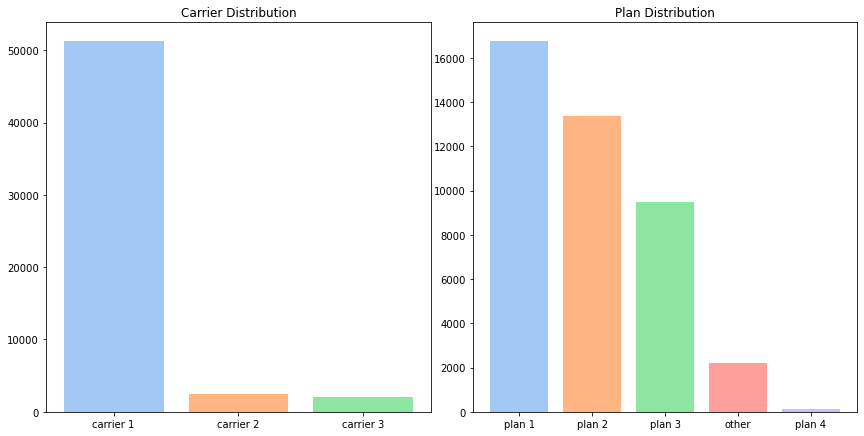

In [12]:
fig, axs = plt.subplots(1,2, figsize=(12,6))
fig.tight_layout()

axs[0].bar(['carrier 1', 'carrier 2', 'carrier 3'], customer_info['carrier'].value_counts(), color=sns.color_palette('pastel'))
axs[0].set_title('Carrier Distribution')
axs[1].bar(['plan 1', 'plan 2', 'plan 3', 'other', 'plan 4'], customer_info['plan_name'].value_counts(), color=sns.color_palette('pastel'))
axs[1].set_title('Plan Distribution')

In [13]:
customer_info['plan_subtype'].value_counts()

[NULL]    42011
ADD ON        1
Name: plan_subtype, dtype: int64

number of people who redeemed 42012


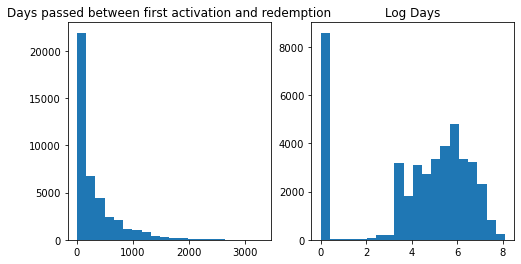

In [14]:
date1 = pd.to_datetime(customer_info.dropna().first_activation_date, format="%Y-%m-%d")
date2 = pd.to_datetime(customer_info.dropna().redemption_date, format="%Y-%m-%d")
log_days = np.log((date2 - date1).dt.days+1)

print(f"number of people who redeemed {len(log_days)}")

fig, axs = plt.subplots(1,2, figsize=(8,4))
axs[0].set_title("Days passed between first activation and redemption")
axs[0].hist((date2 - date1).dt.days+1, bins=20);
axs[1].set_title("Log Days")
axs[1].hist(log_days, bins=20);

In [15]:
def extract2(customer_info, filepath=None, overwrite=False):
    customer_info = customer_info.copy()
    
    df2 = customer_info.copy()
    df2 = pd.concat([df2, pd.get_dummies(df2['carrier'], prefix='carrier')], axis=1)

    date1 = pd.to_datetime(df2['first_activation_date'], format="%Y-%m-%d")
    date2 = pd.to_datetime(df2['redemption_date'], format="%Y-%m-%d")
    df2["days_to_redemption"] = np.log((date2 - date1).dt.days+1)
    df2['days_to_redemption'].fillna((df2['days_to_redemption'].median()), inplace=True)    
    scaler = MinMaxScaler()
    df2['days_to_redemption'] = scaler.fit_transform(df2['days_to_redemption'].values.reshape(-1,1))

    df2 = pd.concat([
        df2,
        pd.get_dummies(df2['plan_name'], prefix='plan')
    ], axis=1)

    df2.drop(
        ['carrier', 'first_activation_date', 'plan_subtype', 'redemption_date', 'plan_name'], 
        axis=1, inplace=True
    )

    return df2

df2 = extract2(customer_info)
df2.head(2)

,line_id,carrier_carrier 1,carrier_carrier 2,carrier_carrier 3,days_to_redemption,plan_Other,plan_plan 1,plan_plan 2,plan_plan 3,plan_plan 4
0,e1b8b731-f3c6-4a8a-b09c-f3556888c868,1,0,0,0.618770,0,0,0,0,0
1,51c1e947-f8a4-4a9c-94f8-45f52198f329,1,0,0,0.452418,0,0,1,0,0


## 3. Phone Info

- `cpu_cores`, `expandable_storage`
    - Set Nan to 1 for CPU
    - Set Nan to 0 for expandable_storage
    - Measure of how good the phone is
    - If its a sum, make sure to add them together.
- `gsma_device_type`
    - Smartphone, Mobile Phone. Handheld, WLAN Router, Tablet, Modem
    - one hot encode this
- `gsma_model_name`
    - Only 11571 / 55868 nulls.
    - 869 values, most of which are just 1
    - Can just treat anything under 100 or NAN as 'other'
- `gsma_operating_system`
    - 90% are in Android, IOS, Linux, or Unknown
    - A few of the other fields can be merged into one of the above
    - Can safely treat everything else as 'Other', and just not have that field when one hot encoding
- `time_since_phone_release`
    - Time in months, logged
- `internal_storage_capacity`
    - Set NaN to average
    - For everything else, split up and pick the median. 
- `lte`, `lte_advanced`, `touch_screen`, `wi_fi`
    - Set Nan to 0
- `lte_category`
    - This is categorical, not numerical
    - <https://www.cablefree.net/wirelesstechnology/4glte/lte-ue-category-class-definitions/>
    - Look at this link to see the upload and download speeds, and use that as new features
- `total_ram`
    - Set Nan to median
- `years_since_released`
    - Get log of that to the current date.

In [16]:
phone_info=pd.read_csv(data_folder+"data/dev/phone_info.csv")
phone_info.head(5)

,line_id,cpu_cores,expandable_storage,gsma_device_type,gsma_model_name,gsma_operating_system,internal_storage_capacity,lte,lte_advanced,lte_category,manufacturer,os_family,os_name,os_vendor,os_version,sim_size,total_ram,touch_screen,wi_fi,year_released
0,8803884c-38df-4243-a522-891c2117790c,4,0.0,Smartphone,iPhone 7 (A1779),iOS,32/128/256,1.0,1.0,9.0,Apple,iOS,iOS,Apple,10,Nano,2048,1.0,1.0,2016.0
1,75b2d7a7-c4f8-4cf2-af32-ab25b5dffacc,8,1.0,Smartphone,SM-N975U,Android,256,1.0,1.0,20.0,Samsung,Android,Android,Google,9,Nano,8192,1.0,1.0,2019.0
2,7f10447b-7ce6-4297-9011-8273b11354ee,2+4,0.0,Smartphone,iPhone XR (A1984),iOS,64/128/256,1.0,1.0,12.0,Apple,iOS,iOS,Apple,12,Nano,3072,1.0,1.0,2018.0
3,50579bcb-6413-4dfb-865d-f11d3adad1fe,NaN,NaN,Smartphone,SM-G986U1,Android,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,c56e177c-0514-493c-bbc2-7e2c9308aa73,NaN,NaN,Smartphone,LG L722DL,Android,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
len(phone_info)

55868

In [18]:
print(phone_info['gsma_device_type'].value_counts())


Smartphone                    43230
Mobile Phone/Feature phone      944
Handheld                        119
WLAN Router                       2
Tablet                            1
Modem                             1
Name: gsma_device_type, dtype: int64


In [19]:
phone_info['gsma_model_name'].value_counts(dropna=False)

NaN                       11571
iPhone 7 (A1660)           5405
iPhone 6S (A1633)          3188
XT2005DL                   2311
iPhone 6S Plus (A1634)     1726
                          ...  
LG-H810                       1
LG-H873                       1
LG-LS777                      1
iPhone 6S Plus (A1699)        1
LG-M210                       1
Name: gsma_model_name, Length: 869, dtype: int64

In [20]:
with pd.option_context("display.max_rows", 20):
    print(phone_info['gsma_operating_system'].value_counts(dropna=False))

Android              22291
iOS                  21129
NaN                  11571
Not Known              540
NONE                   192
Linux                  112
Not Known,iOS           10
Other                    6
Android,Not Known        6
KaiOS                    3
Windows Phone            3
Android,MTK              1
Android,SC6800H          1
Not known                1
Blackberry               1
Not known,iOS            1
Name: gsma_operating_system, dtype: int64


In [21]:
def minmax_scale(series):
    scaler = MinMaxScaler()
    return scaler.fit_transform(series.values.reshape(-1,1))

def standard_scale(series):
    scaler = StandardScaler()
    return scaler.fit_transform(series.values.reshape(-1,1))

def robust_scale(series):
    scaler = RobustScaler()
    return scaler.fit_transform(series.values.reshape(-1,1))

In [22]:
def get_first_number(s):
    return int(re.search(r'\d+', str(s)).group())

In [23]:
def split_external_storage_capacity(s):
    s = str(s)
    if s == 'nan':
        return np.nan
    if '.' in s:
        return float(s)
    capacities = np.array(list(map(float, s.split('/'))))
    capacity = np.median(capacities)
    return capacity

In [24]:
def convert_to_datetime(series):
    return pd.to_datetime(series, format="%Y-%m-%d")

In [25]:
lte_downlink = {0:1,1:10,2:50,3:100,4:150,5:300,6:300,7:300,8:3000,9:450,10:450,11:600,12:600,13:390,14:3900,15:800,16:1050,17:25000,18:1200,19:1600,20:2000,21:1400}
lte_uplink = {0:1,1:5,2:25,3:50,4:50,5:75,6:50,7:100,8:1500,9:50,10:100,11:50,12:100,13:150,14:1500,15:220,16:100,17:2100,18:210,19:13500,20:315,21:300}    

In [26]:
def extract3(phone_info, upgrades, filepath=None, overwrite=False):
    if not filepath:
        filepath = "pickles/df3.pickle"
    if is_cached(filepath) and not overwrite:
        return load_cache(filepath)
    
    phone_info = phone_info.copy()
    
    # get has_phone
    df3 = phone_info.copy()
    df3['has_phone'] = np.where(df3['cpu_cores'].isnull(), 0, 1)

    # get total cpus
    df3['cpu_cores'] = df3['cpu_cores'].dropna().apply(str).apply(eval)
    df3['cpu_cores'].fillna(df3['cpu_cores'].median(), inplace=True)
    scaler = MinMaxScaler()
    df3['cpu_cores'] = scaler.fit_transform(df3['cpu_cores'].values.reshape(-1,1))
    
    # expandable storage
    df3['expandable_storage'].fillna(0, inplace=True)
    
    # remove uncommon device types
    df3['gsma_device_type'].replace('WLAN Router', 'Other', inplace=True)
    df3['gsma_device_type'].replace('Tablet', 'Other', inplace=True)
    df3['gsma_device_type'].replace('Modem', 'Other', inplace=True)
    df3 = pd.concat([df3, pd.get_dummies(df3['gsma_device_type'], prefix='device_type')], axis=1)
    df3.drop(['gsma_device_type', 'device_type_Other'], axis=1, inplace=True)
    
    df3.drop(['gsma_model_name'], axis=1, inplace=True)
    
    # operating system
    df3['gsma_operating_system'].loc[
        (df3['gsma_operating_system'] != 'Android') &
        (df3['gsma_operating_system'] != 'iOS') &
        (df3['gsma_operating_system'] != 'Linux')
    ] = 'Other'
    df3 = pd.concat([df3, pd.get_dummies(df3['gsma_operating_system'], prefix='os')], axis=1)
    df3.drop(
        ['gsma_operating_system', 'os_family', 'os_name', 'os_vendor', 'os_version', 
         'manufacturer', 'os_Other'], axis=1, inplace=True)
    
    # internal stroage capacity, use medians
    df3['internal_storage_capacity'] = df3['internal_storage_capacity'].apply(split_external_storage_capacity)
    df3['internal_storage_capacity'].fillna(df3['internal_storage_capacity'].median(), inplace=True)
    df3['internal_storage_capacity'] = np.log2(df3['internal_storage_capacity'])
    scaler = StandardScaler()
    df3['internal_storage_capacity'] = scaler.fit_transform(df3['internal_storage_capacity'].values.reshape(-1,1))
    
    df3['lte'].fillna(0, inplace=True)
    df3['lte_advanced'].fillna(0, inplace=True)
    
    df3['lte_category'].fillna(df3['lte_category'].dropna().mode()[0], inplace=True)
    df3['lte_downlink'] = df3['lte_category'].map(lte_downlink)
    df3['lte_uplink'] = df3['lte_category'].map(lte_uplink)
    scaler = RobustScaler()
    df3['lte_downlink'] = scaler.fit_transform(df3['lte_downlink'].values.reshape(-1,1))
    df3['lte_uplink'] = scaler.fit_transform(df3['lte_uplink'].values.reshape(-1,1))
    df3['lte_downlink'] /= 100
    df3['lte_uplink'] /= 100
    df3.drop(['lte_category'], axis=1, inplace=True)
    
    df3.drop(['sim_size'], axis=1, inplace=True)
    
    df3['total_ram'] = df3['total_ram'].apply(split_external_storage_capacity)
    df3['total_ram'].fillna(df3['total_ram'].median(), inplace=True)
    df3['total_ram'] = np.log2(df3['total_ram'])
    scaler = MinMaxScaler()
    df3['total_ram'] = scaler.fit_transform(df3['total_ram'].values.reshape(-1,1))
    df3['touch_screen'].fillna(0, inplace=True)
    df3['wi_fi'].fillna(0, inplace=True)
        
    # years since release
    df3 = pd.merge(df3, upgrades[['line_id', 'date_observed']].copy(), on='line_id')
    df3['date_observed'] = pd.to_datetime(df3['date_observed'], format="%Y-%m-%d").dt.year
    
    df3['years_since_release'] = df3['date_observed'] - df3['year_released']
    df3['years_since_release'].fillna(df3['years_since_release'].dropna().median(), inplace=True)
    df3['years_since_release'] = minmax_scale(df3['years_since_release'])
    
    df3.drop(['date_observed', 'year_released'], axis=1, inplace=True)
    
    cache(df3, filepath)
    
    return df3

In [27]:
df3 = extract3(phone_info, upgrades, overwrite=True)
print(len(df3))
df3.head(2)

55868


,line_id,cpu_cores,expandable_storage,internal_storage_capacity,lte,lte_advanced,total_ram,touch_screen,wi_fi,has_phone,device_type_Handheld,device_type_Mobile Phone/Feature phone,device_type_Smartphone,os_Android,os_Linux,os_iOS,lte_downlink,lte_uplink,years_since_release
0,8803884c-38df-4243-a522-891c2117790c,0.428571,0.0,1.013039,1.0,1.0,0.776869,1.0,1.0,1,0,0,1,0,0,1,0.0,0.00,0.333333
1,75b2d7a7-c4f8-4cf2-af32-ab25b5dffacc,1.000000,1.0,1.943379,1.0,1.0,0.949507,1.0,1.0,1,0,0,1,1,0,0,15.5,2.65,0.000000


## 4. Redemptions

- `num_redemptions`
    - We can count how many times people have redeemed to see how dedicated they are to the plan
- `num_one_offs`
    - Number of one off calls they've made. 
    - Indicates how much money they have.
    - log, standard
- `total_spent`
    - Sum of gross revenues
    - log, standard
- `average_monthly_spend`
    - total_spent divided by number of months redeemed
- `monthly_plan_cost`
    - get the median of all expenditures above 15. 0 if none. 
    - This is most likely the montly fee they must pay. 
    - log, min_max
- notes:
    - For those that redeem 100s of times, check to see the dates they redeem at.
        - looking at the biggest spenders, they pay a monthly fee of above 15
        - then, they have periods where they constantly pay 5-10 at a time like 10 times in a month.
        - We can grab the median above 15 and use that as the monthly subscription cost.

In [28]:
redemptions=pd.read_csv(data_folder+"data/dev/redemptions.csv")
print(f"number of redemptions: {len(redemptions)}")
redemptions.head(5)

number of redemptions: 641493


,line_id,channel,gross_revenue,redemption_date,redemption_type,revenue_type
0,003a475f-a35c-4d9d-b72d-178dede369e3,APP,35.0,2020-08-31,MPPAID,MPPAID
1,a753a5d8-3260-41bc-aba0-84dde1c7c4c0,WEB,50.0,2021-01-28,MPPAID,MPPAID
2,45436c39-7de2-4270-ac15-2ffd4466a5a1,WEB,35.0,2021-02-05,MPPAID,MPPAID
3,4ace8faa-6433-4715-8a15-9bd6abf074f2,IVR,15.0,2018-10-16,MPPAID,MPPAID
4,04918ddd-77b3-4e43-aa60-4796795e0292,IVR,44.0,2019-05-04,MPPAID,MPPAID


In [29]:
redemptions.revenue_type.value_counts(dropna=False)

MPPAID     637145
REPL         2157
FREE         1408
PAID          695
BP PAID        75
LL BILL        13
Name: revenue_type, dtype: int64

In [30]:
redemptions.redemption_type.value_counts(dropna=False)

MPPAID                        637145
Replacement                     2157
FREE                            1325
PAID                             695
BP PAID                           75
CORP FREE SALES                   34
CORP FREE - LOGISTICS             16
LL BILL                           13
CORP FREE MERCHANDISING           11
CORP FREE APP                      9
CORP FREE - IT DEVELOPMENT         8
Customer Service                   5
Name: redemption_type, dtype: int64

num redemptions: 54885
line_id
d929c4ef-35b8-4562-97e8-f94eb01150fb    133
f88fbc04-23da-4c67-911d-8c88eb1d2991    118
1e1f91ba-c665-4c96-acec-1104f586f7f8    108
3859e4af-bf13-4731-8f8f-a3f877257428    104
2f48dde2-a816-42f6-8f67-ab4c689c8b0a    103
                                       ... 
81eb967e-5f8d-4bee-bd99-dbed3908d244      1
2f0f5850-7818-4721-a66b-f35921d003c7      1
abd70f1e-25d1-4ecd-b1e6-420f4ca9d56b      1
2f0a9d50-89ca-44c1-b7c8-fd3bda90213b      1
a3185885-d4ca-4736-b509-61f05ab30c43      1
Length: 54885, dtype: int64


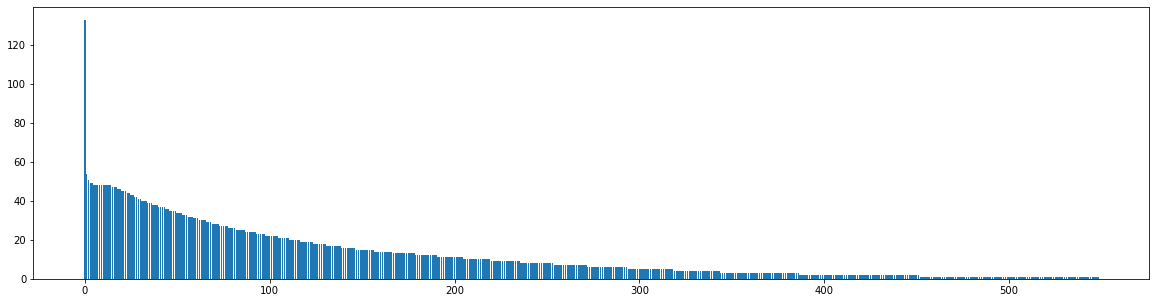

In [31]:
reds = redemptions.dropna().groupby(['line_id']).size().sort_values(ascending=False)
plt.figure(figsize=(20,5))
plt.bar(range(len(reds[::100])), reds[::100])
print("num redemptions:", len(reds))
print(reds)

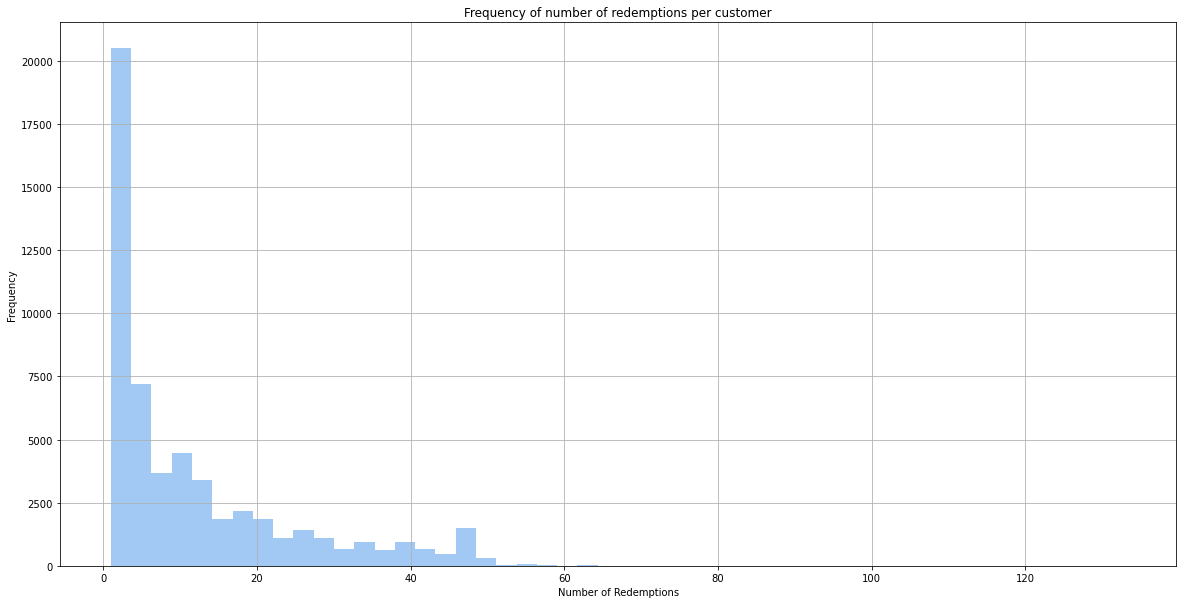

In [32]:
redemption_count = redemptions.dropna().groupby(['line_id']).size().to_frame('redemption_count')
plt.figure(figsize=(20,10))
plt.title('Frequency of number of redemptions per customer')
plt.grid()
plt.hist(redemption_count, bins=50, color=sns.color_palette('pastel')[0])
plt.xlabel('Number of Redemptions')
plt.ylabel('Frequency');

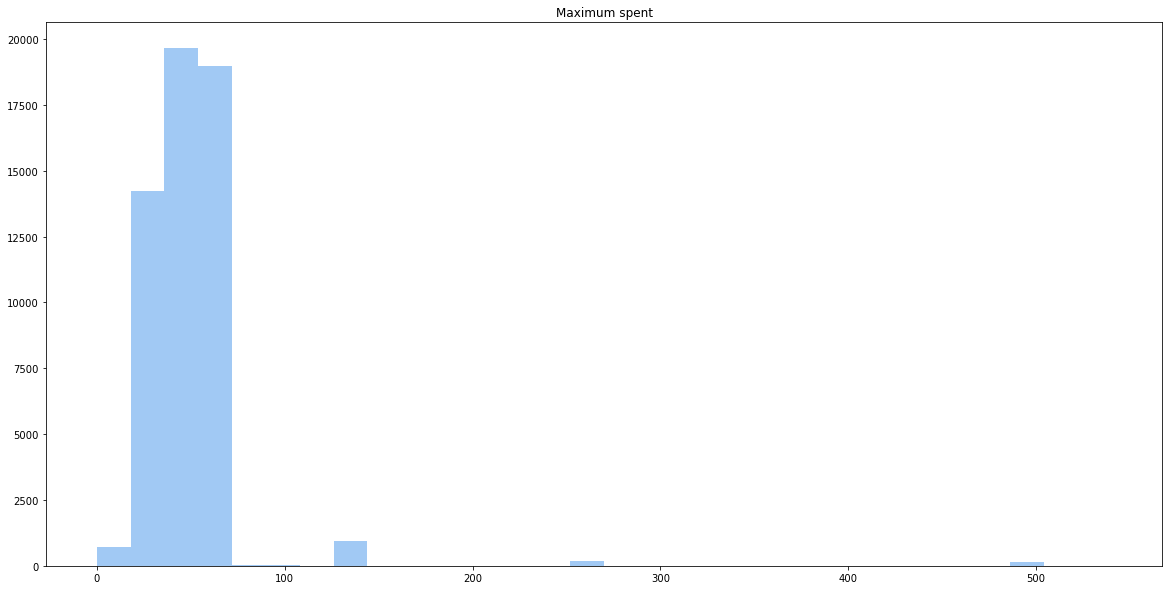

In [33]:
max_gross_revenue = redemptions.dropna().groupby(['line_id'])['gross_revenue'].max()
plt.figure(figsize=(20,10))
plt.title('Maximum spent')
plt.hist(max_gross_revenue, bins=30, color=sns.color_palette('pastel')[0]);

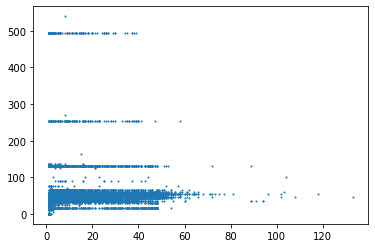

In [34]:
tempdf = pd.merge(redemption_count, max_gross_revenue, on='line_id')
plt.scatter(tempdf['redemption_count'], tempdf['gross_revenue'], s=1)

In [35]:
def remove_outliers(data, upper_quantile=.95, lower_quantile=.05):
    upper_lim = data.quantile(upper_quantile)
    lower_lim = data.quantile(lower_quantile)
    
    no_outliers = data[(data < upper_lim) & (data > lower_lim)]
    return no_outliers

In [36]:
print("num redemptions above 100:", len(redemptions[redemptions['gross_revenue'] >= 100])) ## outliers
print("num redemptions total:", len(redemptions))

num redemptions above 100: 3258
num redemptions total: 641493


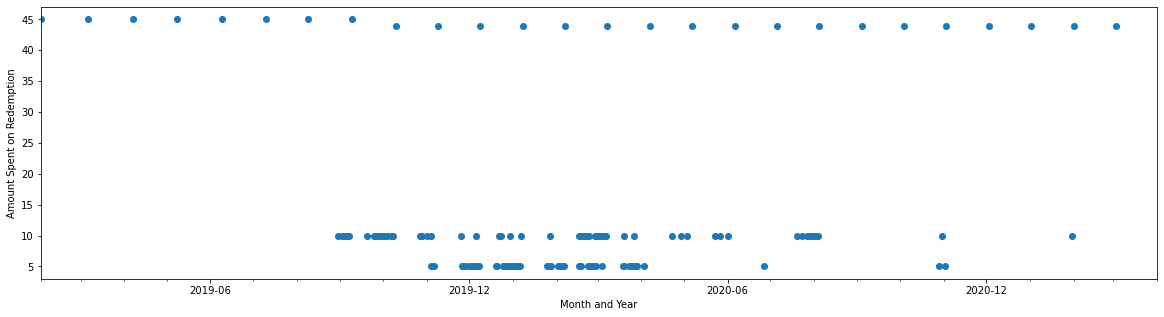

In [71]:
import matplotlib.dates as mdates
target_id = 'd929c4ef-35b8-4562-97e8-f94eb01150fb'
sample_reds = redemptions[redemptions['line_id'] == target_id][['gross_revenue','redemption_date','revenue_type']].sort_values('redemption_date')
sample_reds['redemption_date'] = pd.to_datetime(sample_reds['redemption_date'], format="%Y-%m-%d")

# sample_reds = sample_reds[sample_reds['revenue_type']=='FREE']

plt.figure(figsize=(20,5))

fmt_half_year = mdates.MonthLocator(interval=6)
plt.gca().xaxis.set_major_locator(fmt_half_year)
fmt_month = mdates.MonthLocator()
plt.gca().xaxis.set_minor_locator(fmt_month)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
datemin = np.datetime64(min(sample_reds['redemption_date']), 'M')
datemax = np.datetime64(max(sample_reds['redemption_date']), 'M') + np.timedelta64(1, 'M')
plt.gca().set_xlim(datemin, datemax)
plt.gca().format_xdata = mdates.DateFormatter('%Y-%m')
plt.gca().set_xlabel('Month and Year')
plt.gca().set_ylabel('Amount Spent on Redemption')

plt.plot_date(sample_reds['redemption_date'], sample_reds['gross_revenue']);

In [38]:
def extract4(redemptions, upgrades, filepath=None, overwrite=False):
    if not filepath:
        filepath = "pickles/df4.pickle"
    if is_cached(filepath) and not overwrite:
        return load_cache(filepath)
    
    redemptions = redemptions.copy()
    df4 = upgrades[['line_id']].copy()
    
    #num redemptions
    num_redemptions = redemptions.groupby(['line_id']).size().to_frame('num_redemptions')
    df4 = pd.merge(df4, num_redemptions, on='line_id', how='left')
    df4['num_redemptions'].fillna(0, inplace=True)
    df4['num_redemptions'] = np.log(df4['num_redemptions']+1)
    scaler = MinMaxScaler()
    df4['num_redemptions'] = scaler.fit_transform(df4['num_redemptions'].values.reshape(-1,1))
    
    # num one offs
    one_off_threshold = 15
    num_one_offs = redemptions[redemptions['gross_revenue'] <= one_off_threshold].groupby(['line_id']).size().to_frame('num_one_offs')
    df4 = pd.merge(df4, num_one_offs, on='line_id', how='left')
    df4['num_one_offs'].fillna(0, inplace=True)
    df4['num_one_offs'] = np.log(df4['num_one_offs']+1)
    scaler = MinMaxScaler()
    df4['num_one_offs'] = scaler.fit_transform(df4['num_one_offs'].values.reshape(-1,1))
    
    # total spent
    total_spent = redemptions.groupby(['line_id'])['gross_revenue'].sum().to_frame('total_spent')
    df4 = pd.merge(df4, total_spent, on='line_id', how='left')
    df4['total_spent'].fillna(0, inplace=True)
    
    # average monthly
    redemptions['redemption_date'] = pd.to_datetime(redemptions['redemption_date'], format="%Y-%m-%d")
    date_start = redemptions.groupby(['line_id'])['redemption_date'].min().to_frame('date_start')
    df4 = pd.merge(df4, date_start, on='line_id', how='left')
    date_end = redemptions.groupby(['line_id'])['redemption_date'].max().to_frame('date_end')
    df4 = pd.merge(df4, date_end, on='line_id', how='left')
    df4['date_start'].fillna(np.datetime64('1970'), inplace=True)
    df4['date_end'].fillna(np.datetime64('1970'), inplace=True)
    
    df4['total_months'] = (df4['date_end'] - df4['date_start']).dt.days//30+1
    df4['average_monthly_spend'] = df4['total_spent'] / df4['total_months']
    df4.drop(['date_start', 'date_end', 'total_months'], axis=1, inplace=True)
    
    df4['total_spent'] = np.log(df4['total_spent']+1)
    scaler = StandardScaler()
    df4['total_spent'] = scaler.fit_transform(df4['total_spent'].values.reshape(-1,1))
    
    df4['average_monthly_spend'] = np.log(df4['average_monthly_spend']+1)
    scaler = MinMaxScaler()
    df4['average_monthly_spend'] = scaler.fit_transform(df4['average_monthly_spend'].values.reshape(-1,1))
    
    # monthly plan cost
    monthly_plan_cost = redemptions[redemptions['gross_revenue'] > one_off_threshold].groupby(['line_id']).median()
    monthly_plan_cost = monthly_plan_cost.rename(columns={'gross_revenue':'monthly_plan_cost'})
        
    df4 = pd.merge(df4, monthly_plan_cost, on='line_id', how='left')
    df4['monthly_plan_cost'].fillna(0, inplace=True)
    df4['monthly_plan_cost'] = np.log(df4['num_one_offs']+1)
    scaler = MinMaxScaler()
    df4['monthly_plan_cost'] = scaler.fit_transform(df4['num_one_offs'].values.reshape(-1,1))
    
    cache(df4, filepath)
    
    return df4

In [39]:
df4 = extract4(redemptions, upgrades, overwrite=True)
print(len(df4))
df4.head(2)

55868


,line_id,num_redemptions,num_one_offs,total_spent,average_monthly_spend,monthly_plan_cost
0,f0b99d3b-32f7-4464-8fa8-87f27c9810a8,0.707605,0.0,1.236259,0.614134,0.0
1,a2ec0baf-1720-4b1b-bfa3-db00ac8fcb00,0.665211,0.0,1.183022,0.648965,0.0


## 5. Deactivations

- `deactivation_reason`
    - some of the values are very important. namely
        - "PASTDUE"
        - "UPGRADE"
        - "DEVICE CHANGE INQUIRY"
        - "STOLEN"
        - "DEFECTIVE"
        - "ACTIVE UPGRADE"
        - "REFURBISHED"
        - "NO NEED OF PHONE"
        - "DEVICERETURN"
    - everything else can be just grouped into "OTHER"
- `has_deactivated`
    - 1 or 0 storing if they have deactivated or not.
    - This can be cancelled out later by the `has_reactivated` field
- `num_deactivations`
    - Some people have deactivated multiple times

In [40]:
deactivations=pd.read_csv(data_folder+"data/dev/deactivations.csv")
print(f"number of deactivations: {len(deactivations)}")
deactivations.head(5)

number of deactivations: 256754


,line_id,deactivation_date,deactivation_reason
0,bbc9e615-39c0-4c2f-93b1-67a1f50cacda,2020-06-11,PASTDUE
1,61c2a41e-f827-4c0c-a5cd-97396c5ed8b7,2019-06-02,PASTDUE
2,33f4c1e0-12fc-4173-8c26-cc8dfe48138e,2019-09-13,PASTDUE
3,512ba065-9ab6-4d27-9e4e-ec388830ddad,2019-02-24,PASTDUE
4,b00ddd78-640e-47f4-8553-1d1907d6abaf,2019-09-24,PASTDUE


In [41]:
with pd.option_context("display.max_rows", 23):
    print(deactivations['deactivation_reason'].value_counts(dropna=False))

PASTDUE                  254232
UPGRADE                     673
CUSTOMER REQD               670
RISK ASSESSMENT             472
PORT OUT                    234
DEVICE CHANGE INQUIRY        95
STOLEN CREDIT CARD           81
STOLEN                       73
MINCHANGE                    61
SENDCARRDEACT                56
CHANGE OF ADDRESS            41
ACTIVE UPGRADE               13
PORTED NO A/I                13
WN-SYSTEM ISSUED              9
REFURBISHED                   8
PORT CANCEL                   7
NO NEED OF PHONE              4
DEFECTIVE                     4
REMOVED_FROM_GROUP            3
LINE HOTLINED                 2
DEVICERETURN                  1
SIM EXCHANGE                  1
AVFAILURE                     1
Name: deactivation_reason, dtype: int64


In [42]:
deactivations.dropna().groupby(['line_id']).size().sort_values(ascending=False)

line_id
6584051d-9190-4812-ba2b-f59ba0e5f350    47
5f24bef0-3545-408a-9651-796a4679364d    47
ee5041a8-f6cc-42f7-96ef-399bfaafe2c8    46
746f66a8-826c-4c9b-934f-6d3747695684    46
1e5af487-4ce9-4919-8e45-64b40d7634b1    46
                                        ..
655ef649-6881-4099-b032-da44790ef83a     1
c7a4f16d-cc8c-498e-998e-409dca00cf26     1
655f8a45-e2d3-4265-b5a3-6abde8018409     1
c7a9ea3c-38c9-4201-b77e-2cbabfc9e6c0     1
4090da61-4c08-45a5-b554-a4d846065daf     1
Length: 44757, dtype: int64

In [43]:
def extract5(deactivations, upgrades, filepath=None, overwrite=False):
    if not filepath:
        filepath = "pickles/df5.pickle"
    if is_cached(filepath) and not overwrite:
        return load_cache(filepath)
    
    deactivations = deactivations.copy()
    df5 = upgrades[['line_id']].copy()
    
    # has deactivated
    has_deactivated = deactivations.groupby('line_id')['deactivation_reason'].any()
    has_deactivated = has_deactivated.rename(f'has_deactivated')
    df5 = pd.merge(df5, has_deactivated, on='line_id', how='left')
    df5[f'has_deactivated'].replace({np.nan:0, True:1}, inplace=True)
    
    # has certain deactivation reasons
    useful_values = ["PASTDUE", "UPGRADE", "DEVICE CHANGE INQUIRY", "STOLEN", 
                    "DEFECTIVE", "ACTIVE UPGRADE", "REFURBISHED", "NO NEED OF PHONE", "DEVICERETURN"]
    for useful_value in useful_values: 
        has_value = deactivations[deactivations['deactivation_reason'] == useful_value].groupby('line_id')['deactivation_reason'].any()
        has_value = has_value.rename(f'reason_{useful_value}')
        df5 = pd.merge(df5, has_value, on='line_id', how='left')
        df5[f'reason_{useful_value}'].replace({np.nan:0, True:1}, inplace=True)

    # num deactivations
    num_deactivations = deactivations.groupby(['line_id']).size().to_frame('num_deactivations')
    df5 = pd.merge(df5, num_deactivations, on='line_id', how='left')
    df5['num_deactivations'].fillna(0, inplace=True)
    df5['num_deactivations'] = np.log(df5['num_deactivations']+1)
    df5['num_deactivations'] = minmax_scale(df5['num_deactivations'])
        
    cache(df5, filepath)
        
    return df5

In [44]:
df5 = extract5(deactivations, upgrades, overwrite=True)
df5.head(5)

,line_id,has_deactivated,reason_PASTDUE,reason_UPGRADE,reason_DEVICE CHANGE INQUIRY,reason_STOLEN,reason_DEFECTIVE,reason_ACTIVE UPGRADE,reason_REFURBISHED,reason_NO NEED OF PHONE,reason_DEVICERETURN,num_deactivations
0,f0b99d3b-32f7-4464-8fa8-87f27c9810a8,0,0,0,0,0,0,0,0,0,0,0.000000
1,a2ec0baf-1720-4b1b-bfa3-db00ac8fcb00,1,1,0,0,0,0,0,0,0,0,0.358104
2,dd3a01a3-7baf-4605-9799-ce434328a20d,1,1,0,0,0,0,0,0,0,0,0.415746
3,5cf5917c-f407-4cc7-9d6d-dafe8ec0eccc,0,0,0,0,0,0,0,0,0,0,0.000000
4,6437fcbd-02c4-4c52-b5b2-f7e535ecec47,1,1,0,0,0,0,0,0,0,0,0.179052


## 6. Reactivations

- `num_reactivations`
    - some people have reactivated multiple times
    - no clue why, but I'll store it anyway
- `days_since_most_recent_reactivation`
    - store the days since most recent reactivation
- `is_active`
    - take the last deactivations date, and check to see if it is before the last reactivation date

In [45]:
reactivations=pd.read_csv(data_folder+"data/dev/reactivations.csv")
reactivations.head(2)

,line_id,reactivation_channel,reactivation_date
0,f72d37a7-50a0-4ed0-95e6-5aaa47c8691f,WEB,2020-08-01
1,b71f5bed-3e65-48b2-ae3f-d8b1a427b29f,WEB,2020-01-23


In [46]:
len(reactivations)

248597

In [47]:
reactivations.dropna().groupby(['line_id']).count()['reactivation_channel'].sort_values(ascending=False)

line_id
5f24bef0-3545-408a-9651-796a4679364d    47
6584051d-9190-4812-ba2b-f59ba0e5f350    47
2b6c6476-cb13-43b4-9adc-7e74a5f38d04    46
7d8076f0-d74d-42e1-8491-8515fd60f07d    46
1e5af487-4ce9-4919-8e45-64b40d7634b1    46
                                        ..
9a12631c-023e-43e6-9760-ec838cb84b5f     1
9a142a91-1825-4a48-a0df-0f1ad9ea6069     1
394d820b-300b-45cf-b201-16a5b1875026     1
9a18d579-2b71-44fb-88f8-1b6b926b0ae4     1
81178de0-0d77-4617-b6dd-846b126bde35     1
Name: reactivation_channel, Length: 40992, dtype: int64

In [48]:
def extract6(reactivations, deactivations, upgrades, filepath=None, overwrite=False):
    if not filepath:
        filepath = "pickles/df6.pickle"
    if is_cached(filepath) and not overwrite:
        return load_cache(filepath)
    
    reactivations = reactivations.copy()
    df6 = upgrades[['line_id']].copy()
    
    # check if active
    df6['is_active'] = 1
    
    deactivations['deactivation_date'] = pd.to_datetime(deactivations['deactivation_date'], format="%Y-%m-%d")
    reactivations['reactivation_date'] = pd.to_datetime(reactivations['reactivation_date'], format="%Y-%m-%d")
    
    last_deactivate = deactivations.groupby(['line_id'])['deactivation_date'].max().to_frame('last_deactivate')
    last_reactivate = reactivations.groupby(['line_id'])['reactivation_date'].max().to_frame('last_reactivate')
    
    df6 = pd.merge(df6, last_deactivate, on='line_id', how='left')
    df6 = pd.merge(df6, last_reactivate, on='line_id', how='left')
    
    has_deactivated = deactivations.groupby('line_id')['deactivation_reason'].any()
    has_deactivated = has_deactivated.rename(f'has_deactivated')
    df6 = pd.merge(df6, has_deactivated, on='line_id', how='left')
    df6['has_deactivated'].replace({np.nan:0, True:1}, inplace=True)
    df6['reactivated'] = np.where(df6['last_reactivate'] - df6['last_deactivate'] >= np.timedelta64(0, 'D'), 1, 0)
    
    df6['is_active'] = 1 - df6[f'has_deactivated'] + df6['reactivated']
    
    df6.drop(['last_deactivate', 'has_deactivated', 'reactivated'], axis=1, inplace=True)
    
    #num reactivations
    num_reactivations = reactivations.groupby(['line_id']).size().to_frame('num_reactivations')
    df6 = pd.merge(df6, num_reactivations, on='line_id', how='left')
    df6['num_reactivations'].fillna(0, inplace=True)
    df6['num_reactivations'] = np.log(df6['num_reactivations']+1)
    df6['num_reactivations'] = minmax_scale(df6['num_reactivations'])
    
    # days since last reactivation
    df6 = pd.merge(df6, upgrades[['line_id','date_observed']], on='line_id', how='left')
    
    df6['date_observed'] = convert_to_datetime(df6['date_observed'])
    df6['days_since_reactivation'] = (df6['date_observed'] - df6['last_reactivate']).dt.days
    df6['days_since_reactivation'] = minmax_scale(np.log(df6['days_since_reactivation']+1))
    df6['days_since_reactivation'].fillna(0, inplace=True)
    
    df6.drop(['date_observed', 'last_reactivate'], axis=1, inplace=True)
        
    cache(df6, filepath)
    
    return df6

In [49]:
df6 = extract6(reactivations, deactivations, upgrades, overwrite=True)
print(len(df6))
df6

55868


,line_id,is_active,num_reactivations,days_since_reactivation
0,f0b99d3b-32f7-4464-8fa8-87f27c9810a8,1,0.000000,0.000000
1,a2ec0baf-1720-4b1b-bfa3-db00ac8fcb00,1,0.358104,0.284924
2,dd3a01a3-7baf-4605-9799-ce434328a20d,1,0.415746,0.316531
3,5cf5917c-f407-4cc7-9d6d-dafe8ec0eccc,1,0.179052,0.473936
4,6437fcbd-02c4-4c52-b5b2-f7e535ecec47,1,0.179052,0.642289
...,...,...,...,...
55863,f89b108a-f453-4419-a4dc-5bf8e1cd1f1a,1,0.283791,0.553710
55864,b703f1d4-57ba-48b6-8adf-46d7aba6a406,1,0.502663,0.567121
55865,e3b2212c-906e-4a8f-8307-6b88fc64d7a0,1,0.000000,0.000000
55866,828df9bf-279c-47c3-96c2-92177a50b8fd,1,0.179052,0.342689


## 7. Suspensions

- `has_been_suspended`
- `num_suspensions`
    - some people have been suspsneed many times (up to 100!)
- `months_since_last_suspension`
    - store the days since most recent reactivation, logged.
- `average_suspesnsion_length`

In [50]:
suspensions=pd.read_csv(data_folder+"data/dev/suspensions.csv")
suspensions.head(2)

,line_id,suspension_start_date,suspension_end_date
0,63a3f832-f035-4b99-8b2b-d34ebb0ebf4b,2021-03-10,2021-03-13
1,d9744c2d-36d4-4d46-9dc4-eea1479b0af7,2015-04-02,2015-04-09


In [51]:
def extract7(suspensions, upgrades, filepath=None, overwrite=False):
    if not filepath:
        filepath = "pickles/df7.pickle"
    if is_cached(filepath) and not overwrite:
        return load_cache(filepath)
    
    suspensions = suspensions.copy()
    df7 = upgrades[['line_id', 'date_observed']].copy()
    
    # num and has been suspended
    num_suspensions = suspensions.groupby(['line_id']).size().to_frame('num_suspensions')
    df7 = pd.merge(df7, num_suspensions, on='line_id', how='left');
    df7['num_suspensions'].fillna(0, inplace=True)
    df7['has_been_suspended'] = np.where(df7['num_suspensions'] > 0, 1, 0)
    df7['num_suspensions'] = minmax_scale(np.log(df7['num_suspensions']+1))
    
    # months since last suspension

    df7['date_observed'] = convert_to_datetime(df7['date_observed'])
    suspensions['suspension_start_date'] = convert_to_datetime(suspensions['suspension_start_date'])
    suspensions['suspension_end_date'] = convert_to_datetime(suspensions['suspension_end_date'])

    last_suspension_date = suspensions.groupby('line_id')['suspension_end_date'].max()
    last_suspension_date.rename('last_suspension_date')
    df7 = pd.merge(df7, last_suspension_date, on='line_id', how='left')
    
    df7['months_since_suspended'] = (df7['date_observed'] - df7['suspension_end_date']).dt.days/30+1
    df7['months_since_suspended'].fillna(0, inplace=True)
    df7['months_since_suspended'] = minmax_scale(np.log(df7['months_since_suspended']+1))
    
    df7.drop(['date_observed', 'suspension_end_date'], axis=1, inplace=True)
    
    # average suspension length
    suspensions['suspension_length'] = (suspensions['suspension_end_date'] - suspensions['suspension_start_date']).dt.days
    average_suspension_length = suspensions.groupby('line_id')['suspension_length'].mean().to_frame('average_suspension_length')
    df7 = pd.merge(df7, average_suspension_length, on='line_id', how='left')
    df7['average_suspension_length'].fillna(0, inplace=True)
    df7['average_suspension_length'] = minmax_scale(df7['average_suspension_length']+1)
    
    cache(df7, filepath)
    return df7

In [52]:
df7 = extract7(suspensions, upgrades, overwrite=True)
print(len(df7))
df7.head(5)

55868


,line_id,num_suspensions,has_been_suspended,months_since_suspended,average_suspension_length
0,f0b99d3b-32f7-4464-8fa8-87f27c9810a8,0.292702,1,0.725469,0.400000
1,a2ec0baf-1720-4b1b-bfa3-db00ac8fcb00,0.292702,1,0.169037,0.033333
2,dd3a01a3-7baf-4605-9799-ce434328a20d,0.410859,1,0.176919,0.388889
3,5cf5917c-f407-4cc7-9d6d-dafe8ec0eccc,0.000000,0,0.000000,0.000000
4,6437fcbd-02c4-4c52-b5b2-f7e535ecec47,0.598204,1,0.361410,0.037500


In [53]:
len(suspensions)

535849

In [54]:
suspensions.dropna().groupby(['line_id']).count()['suspension_start_date'].sort_values(ascending=False)

line_id
1e0891c7-fa49-472b-a5c8-31b7e2ef52cc    113
68a2d2e7-abeb-41f2-964b-0236e8445735    109
bc7eaabf-07b5-433d-b0d3-69fcd33b2c78    108
72fec4c2-4691-4f4b-a9cd-0147f654a386    107
20d48f75-1353-434a-9376-126f0523ae43    107
                                       ... 
ce1dab94-eeb1-4544-8991-688010eff7fc      1
ce1b3665-736b-4c9f-bacb-cb1848a9d9c8      1
571f77cd-7654-494a-a085-63b1e8cd1a8f      1
1f93328e-f892-4a05-a369-3572ae94ac02      1
c6386c5c-f905-4bbe-b997-738a54a1ee62      1
Name: suspension_start_date, Length: 48539, dtype: int64

## 8. Network Usage

- `sms_out_count`, `sms_in_count`
    - number of times they have sms out in total
    - sum together sms and mms as well.
    - log the voice and sms count.
- `hotspot_kb`, `kb_5g`, `total_kb`
    - sum up all usage for each person
    - conver kb to mb or even gb to remove noise
- `voice_count_in`
- `voice_count_out`
- `voice_count_total`
- `total_voice_min`
- `average_call_length`
    - minutes spoken divided by number of calls
- `num_network_usages`
- notes:
    - take into the account the date as well. 
        - should only care about usage in the past 3 months
    - average usage per day, or average usage per week are good statistics.

In [55]:
network_usage_domestic=pd.read_csv(data_folder+"data/dev/network_usage_domestic.csv")
network_usage_domestic.head()

,line_id,date,hotspot_kb,kb_5g,mms_in,mms_out,sms_in,sms_out,total_kb,voice_count_in,voice_count_total,voice_min_in,voice_min_out
0,24daa57d-c261-444c-afd4-c107a53d638e,2021-02-04,0.000000,0.0,0,0,10,7,7.533189e+05,5,8,7,4
1,8ba9b32c-3df3-4145-81ac-f334763a6f43,2021-02-13,166455.194336,0.0,0,0,6,9,2.750695e+06,0,2,0,3
2,58dc79d3-7d8b-46c1-802d-b4330fb61dd2,2020-12-29,0.000000,0.0,2,0,2,1,7.129997e+04,17,53,37,72
3,3d9f79f6-5d82-47bb-9761-bb8534eba8d0,2020-11-10,0.000000,0.0,0,0,1,0,6.085255e+04,3,6,18,7
4,226a8068-f277-4849-9236-b8a46abe14d9,2021-01-07,0.000000,0.0,0,0,3,1,5.648610e+05,3,14,35,38


In [56]:
len(network_usage_domestic)

6381966

In [57]:
def extract8(network_usage, upgrades, filepath=None, overwrite=False):
    if not filepath:
        filepath = "pickles/df8.pickle"
    if is_cached(filepath) and not overwrite:
        return load_cache(filepath)
    
    network_usage = network_usage.copy()
    df8 = upgrades[['line_id']].copy()
    
    # sms/mms in and out
    print("  sms and mms...")
    sms_in_total = (network_usage.groupby('line_id')['mms_in'].sum() +
         network_usage.groupby('line_id')['sms_in'].sum()).to_frame('sms_in_total')
    df8 = pd.merge(df8, sms_in_total, on='line_id', how='left')
    df8['sms_in_total'].fillna(0, inplace=True)    
    
    sms_out_total = (network_usage.groupby('line_id')['mms_out'].sum() +
         network_usage.groupby('line_id')['sms_out'].sum()).to_frame('sms_out_total')
    df8 = pd.merge(df8, sms_out_total, on='line_id', how='left')
    df8['sms_out_total'].fillna(0, inplace=True)  
    
    df8['sms_diff'] = df8['sms_in_total'] - df8['sms_out_total']
    df8['sms_total'] = df8['sms_in_total'] + df8['sms_out_total']
    
    df8['over_15_sms'] = np.choose(df8['sms_total'] >= 15, [0, 1])
    
    # kilobytes of data
    print("  kilobytes of data...")
    hotspot_kb = network_usage.groupby('line_id')['hotspot_kb'].sum()
    df8 = pd.merge(df8, hotspot_kb, on='line_id', how='left')
    df8['hotspot_kb'].fillna(0, inplace=True)  
    df8['hotspot_gb'] = df8['hotspot_kb'] / 1024.0 / 1024.0
    
    kb_5g = network_usage.groupby('line_id')['kb_5g'].sum()
    df8 = pd.merge(df8, kb_5g, on='line_id', how='left')
    df8['kb_5g'].fillna(0, inplace=True) 
    df8['gb_5g'] = df8['kb_5g'] / 1024.0 / 1024.0
             
    total_kb = network_usage.groupby('line_id')['total_kb'].sum()
    df8 = pd.merge(df8, total_kb, on='line_id', how='left')
    df8['total_kb'].fillna(0, inplace=True)  
    df8['total_gb'] = df8['total_kb'] / 1024.0 / 1024.0
    
    df8.drop(['hotspot_kb', 'kb_5g', 'total_kb'], axis=1, inplace=True)
    
    # voice counts
    print("  voice counts...")
    voice_count_in = network_usage.groupby('line_id')['voice_count_in'].sum()
    df8 = pd.merge(df8, voice_count_in, on='line_id', how='left')
    df8['voice_count_in'].fillna(0, inplace=True) 
    
    voice_count_total = network_usage.groupby('line_id')['voice_count_total'].sum()
    df8 = pd.merge(df8, voice_count_total, on='line_id', how='left')
    df8['voice_count_total'].fillna(0, inplace=True) 
    
    df8['voice_count_out'] = df8['voice_count_total'] - df8['voice_count_in']
    df8['voice_count_diff'] = df8['voice_count_in'] - df8['voice_count_out']  
        
    df8['over_5_voice'] = np.choose(df8['voice_count_total'] >= 5, [0, 1])
        
    # voice minutes
    print("  voice minutes..")
    voice_min_in = network_usage.groupby('line_id')['voice_min_in'].sum()
    df8 = pd.merge(df8, voice_min_in, on='line_id', how='left')
    df8['voice_min_in'].fillna(0, inplace=True) 
    
    voice_min_out = network_usage.groupby('line_id')['voice_min_out'].sum()
    df8 = pd.merge(df8, voice_min_out, on='line_id', how='left')
    df8['voice_min_out'].fillna(0, inplace=True) 
    
    df8['voice_min_total'] = df8['voice_min_in'] + df8['voice_min_out']
    
    # average call length
    df8['average_call_length'] = np.choose(
        df8['voice_count_total'] == 0, 
        [df8['voice_min_total'] / df8['voice_count_total'], 0]
    )
    
    #num usages
    num_network_usages = network_usage.groupby(['line_id']).size().to_frame('num_network_usages')
    df8 = pd.merge(df8, num_network_usages, on='line_id', how='left')
    df8['num_network_usages'].fillna(0, inplace=True)
    df8['num_network_usages'] = np.log(df8['num_network_usages']+1)
    df8['num_network_usages'] = minmax_scale(df8['num_network_usages'])
    
    print("  scaling all parameters..")
    df8['sms_in_total'] = standard_scale(np.log(df8['sms_in_total']+1))
    df8['sms_out_total'] = standard_scale(np.log(df8['sms_out_total']+1))
    df8['sms_total'] = standard_scale(np.log(df8['sms_total']+1))
    df8['sms_diff'] = standard_scale(df8['sms_diff'])
    df8['hotspot_gb'] = standard_scale(np.log(df8['hotspot_gb']+1))
    df8['gb_5g'] = standard_scale(np.log(df8['gb_5g']+1))
    df8['total_gb'] = standard_scale(np.log(df8['total_gb']+1))
    df8['voice_count_in'] = standard_scale(np.log(df8['voice_count_in']+1))
    df8['voice_count_out'] = standard_scale(np.log(df8['voice_count_out']+1))
    df8['voice_count_total'] = standard_scale(np.log(df8['voice_count_total']+1))
    df8['voice_min_in'] = standard_scale(np.log(df8['voice_min_in']+1))
    df8['voice_min_out'] = standard_scale(np.log(df8['voice_min_out']+1))
    df8['voice_min_total'] = standard_scale(np.log(df8['voice_min_total']+1))
    df8['voice_count_diff'] = standard_scale(df8['voice_count_diff'])
    df8['average_call_length'] = standard_scale(np.log(df8['average_call_length']+1))
    
    cache(df8, filepath)
    
    return df8

In [58]:
df8 = extract8(network_usage_domestic, upgrades, overwrite=True)
print(len(df8))
df8.head(2)

  sms and mms...
  kilobytes of data...
  voice counts...
  voice minutes..
  scaling all parameters..
55868


,line_id,sms_in_total,sms_out_total,sms_diff,sms_total,over_15_sms,hotspot_gb,gb_5g,total_gb,voice_count_in,voice_count_total,voice_count_out,voice_count_diff,over_5_voice,voice_min_in,voice_min_out,voice_min_total,average_call_length,num_network_usages
0,f0b99d3b-32f7-4464-8fa8-87f27c9810a8,0.69217,0.528104,0.493521,0.605278,1,-0.347243,-0.019078,0.671488,-0.476495,-1.055135,-2.153463,0.523804,1,-0.523527,-2.126809,-1.004709,-0.369328,1.0
1,a2ec0baf-1720-4b1b-bfa3-db00ac8fcb00,-0.01626,0.135005,-0.115131,0.030105,1,-0.336042,-0.019078,1.071869,0.501460,0.536366,0.588102,-0.081080,1,0.379532,0.064359,0.192206,-0.709071,1.0


## 9. LRP Points

- notes: 
    - There are no duplicate line_ids.
    - 8694/8860 people have no difference between quantity and total_quantity. 
    - remember to ignore all dates before the upgrade date.
    - shoud look at graphs of people over time. 
- `total_quantity`
    - the total quantity of points. default is 0. (I.e, the maximum number of lrp points they have)
- `has_earned_points`
    - not everything who enrols has earned points. 
    - This is a metric of if the person is actually engaging with the system or not.
- `total_spent_lrp`
    - difference between sum of quantities earned vs quantity spent. 
    - a majority are 0, but some have actually spent some points, up to ~28000
- `has_spent`
    - total_quantity is MORE than their quantity
- `days_since_earnt`
    - how long its been since earning

In [59]:
lrp_points=pd.read_csv(data_folder+"data/dev/lrp_points.csv")
lrp_points.head()

,line_id,quantity,status,total_quantity,update_date
0,77f81f11-ed62-438d-9c04-02e3bcc0d756,2180.0,ENROLLED,2180.0,2021-01-02
1,d664604d-8b68-4302-b599-0165df0f27ad,1210.0,ENROLLED,1210.0,2021-01-03
2,9391d70b-14b4-41a6-ab94-130a333a9dc6,258.0,ENROLLED,258.0,2021-01-01
3,d0d9dd33-735d-48cb-b86b-39be4cb9af87,250.0,ENROLLED,250.0,2021-01-23
4,e0be071e-fe84-49a8-9622-cc43aa10fba1,320.0,ENROLLED,320.0,2021-02-21


In [60]:
def extract9(lrp_points, upgrades, filepath=None, overwrite=False):
    if not filepath:
        filepath = "pickles/df9.pickle"
    if is_cached(filepath) and not overwrite:
        return load_cache(filepath)
    
    lrp_points = lrp_points.copy()
    df9 = upgrades[['line_id']].copy()
    
    df9 = pd.merge(df9, lrp_points, on='line_id', how='left')
    
    # total_quantity
    df9['total_quantity'].fillna(0, inplace=True)

    # has_earned_points
    df9['has_earned_points'] = np.where(df9['status'] == 'ENROLLED', 1, 0)
    
    # total_spent
    df9['total_spent_lrp'] = df9['total_quantity'] - df9['quantity']
    df9['total_spent_lrp'].fillna(0, inplace=True)
    
    # has_spent
    df9['has_spent'] = np.where(df9['total_spent_lrp'] > 0, 1, 0)
    
    # days_since_earnt
    df9['update_date'] = convert_to_datetime(df9['update_date'])
    df9 = pd.merge(df9, upgrades[['line_id', 'date_observed']].copy(), on='line_id', how='left')
    df9['date_observed'] = convert_to_datetime(df9['date_observed'])
    
    df9['days_since_update'] = (df9['date_observed'] - df9['update_date']).dt.days
    df9['days_since_update'].fillna(0, inplace=True)
    df9['days_since_update'] = minmax_scale(np.log(df9['days_since_update']+1))
    
    df9.drop(['quantity', 'status', 'update_date', 'date_observed'], axis=1, inplace=True)

    cache(df9, filepath)
    return df9

In [61]:
df9 = extract9(lrp_points, upgrades, overwrite=True)
print(len(df9))
df9.head(10)

55868


,line_id,total_quantity,has_earned_points,total_spent_lrp,has_spent,days_since_update
0,f0b99d3b-32f7-4464-8fa8-87f27c9810a8,0.0,0,0.0,0,0.00000
1,a2ec0baf-1720-4b1b-bfa3-db00ac8fcb00,0.0,0,0.0,0,0.00000
2,dd3a01a3-7baf-4605-9799-ce434328a20d,0.0,0,0.0,0,0.00000
3,5cf5917c-f407-4cc7-9d6d-dafe8ec0eccc,0.0,0,0.0,0,0.00000
4,6437fcbd-02c4-4c52-b5b2-f7e535ecec47,0.0,0,0.0,0,0.00000
5,78aed261-2ea1-4659-89c9-5e437efeeb58,0.0,0,0.0,0,0.00000
6,045c85c4-0795-4554-a6ce-d53aa6d9baca,0.0,0,0.0,0,0.00000
7,29651448-78e2-4328-9d30-45f8ee34b2ff,0.0,0,0.0,0,0.00000
8,f78b1a12-f0e4-4b9d-92a1-47bfd60edd9a,260.0,1,0.0,0,0.18709
9,58975e56-c6ea-4884-89d3-5449b6203b01,0.0,0,0.0,0,0.00000


In [62]:
len(lrp_points)

8860

In [63]:
(lrp_points['total_quantity'] - lrp_points['quantity']).value_counts(ascending=False)

0.0        8694
7000.0       77
250.0        41
200.0        17
14000.0       9
800.0         4
5000.0        4
600.0         3
5200.0        2
21000.0       2
12000.0       1
7400.0        1
6000.0        1
7250.0        1
400.0         1
28000.0       1
dtype: int64

In [64]:
lrp_points.groupby('line_id')['quantity'].sum()

line_id
0006966b-f94f-4f48-8fda-318353467352     790.0
0028a1e6-04f6-410b-ae4d-67415aabbc1e    1331.0
0029992d-3863-4b19-b26e-867d98b8d81a    3098.0
002bd8ae-6a98-45b2-abcd-a0be867ca6ed    3132.0
00307c7f-d837-44d9-b299-c092954acafe     250.0
                                         ...  
ffdf8f7f-9460-430a-bb26-3cbac043fa79    2389.0
ffe57670-08d4-460a-821f-0c809990b9c6     350.0
ffe64eb8-4c52-4f84-9060-e750a5612cb7     911.0
ffe864bf-762e-4011-a115-7f0575cd1908     847.0
ffee7004-d6ad-404f-b8f9-c94d23672cab     670.0
Name: quantity, Length: 8860, dtype: float64

## 10. LRP Enrollment

- `has_enrolled_lrp`
    - 1 or 0 saying if they've enrolled.
- `has_enrolled_twice`
    - if you've enrolled twice
- `months_since_enrollment`
    - default is 0
    - log
    - some people have enrolled twice, take the most recent date

In [65]:
lrp_enrollment=pd.read_csv(data_folder+"data/dev/lrp_enrollment.csv")
lrp_enrollment.head()

,line_id,lrp_enrolled,lrp_enrollment_date
0,487ddc53-0fe4-429e-950d-8f3de2231883,Y,2019-12-02
1,081267e8-6fd7-467e-96e2-758cd8597800,Y,2017-04-30
2,a3982b37-9489-4685-ab75-c0429a2f62ea,Y,2021-01-06
3,f3089423-3c6d-4bfc-97f7-f5f139b526d6,Y,2019-07-06
4,cb1418f2-37dd-4a0e-ae49-2d02e6ac9e0c,Y,2019-12-05


In [66]:
def extract10(lrp_enrollment, upgrades, filepath=None, overwrite=False):
    if not filepath:
        filepath = "pickles/df10.pickle"
    if is_cached(filepath) and not overwrite:
        return load_cache(filepath)
    
    lrp_enrollment = lrp_enrollment.copy()
    df10 = upgrades[['line_id', 'date_observed']].copy()
    
    num_enrols = lrp_enrollment.groupby('line_id').size().to_frame('num_enrols')
    df10 = pd.merge(df10, num_enrols, on='line_id', how='left')
    df10['num_enrols'].fillna(0, inplace=True)
    df10['has_enrolled'] = np.where(df10['num_enrols'] > 0, 1, 0)
    df10['has_enrolled_over_twice'] = np.where(df10['num_enrols'] >= 2, 1, 0)
    
    df10['num_enrols'] = minmax_scale(df10['num_enrols'])
    
    # num months since enrolment
    df10['date_observed'] = convert_to_datetime(df10['date_observed'])
    lrp_enrollment['lrp_enrollment_date'] = convert_to_datetime(lrp_enrollment['lrp_enrollment_date'])
    
    last_enrolled_date = lrp_enrollment.groupby('line_id')['lrp_enrollment_date'].max()
    df10 = pd.merge(df10, last_enrolled_date, on='line_id', how='left')
    
    df10['months_since_enrolled'] = (df10['date_observed'] - df10['lrp_enrollment_date']).dt.days/30+1
    df10['months_since_enrolled'].fillna(0, inplace=True)
    df10['months_since_enrolled'] = standard_scale(np.log(df10['months_since_enrolled']+1))
    
    df10.drop(['date_observed', 'lrp_enrollment_date'], axis=1, inplace=True)
    
    cache(df10, filepath)
    return df10

In [67]:
df10 = extract10(lrp_enrollment, upgrades, overwrite=True)
print(len(df10))
df10.head(5)

55868


,line_id,num_enrols,has_enrolled,has_enrolled_over_twice,months_since_enrolled
0,f0b99d3b-32f7-4464-8fa8-87f27c9810a8,0.5,1,0,2.611383
1,a2ec0baf-1720-4b1b-bfa3-db00ac8fcb00,0.5,1,0,0.841585
2,dd3a01a3-7baf-4605-9799-ce434328a20d,0.0,0,0,-0.624808
3,5cf5917c-f407-4cc7-9d6d-dafe8ec0eccc,0.0,0,0,-0.624808
4,6437fcbd-02c4-4c52-b5b2-f7e535ecec47,0.0,0,0,-0.624808


In [68]:
len(lrp_enrollment)

17634

In [69]:
lrp_enrollment['lrp_enrolled'].value_counts()

Y    17634
Name: lrp_enrolled, dtype: int64

## Final Merge and Save

In [70]:
assert(False)  # block run all from reaching this stage

AssertionError: 

In [ ]:
def merge_and_save(
    upgrades, customer_info, phone_info, redemptions, deactivations,
    reactivations, suspensions, network_usage_domestic, lrp_points, lrp_enrollment, 
    filepath, overwrite=False):
    
    """Extract all features, and then merge them all together"""
    
    print("extracting 1...")
    df1 = extract1(upgrades)
    print("extracting 2...")
    df2 = extract2(customer_info, upgrades)
    print("extracting 3...")
    df3 = extract3(phone_info, upgrades, filepath="pickles/d3_eval.pickle", overwrite=overwrite)
    print("extracting 4...")
    df4 = extract4(redemptions, upgrades, filepath="pickles/d4_eval.pickle", overwrite=overwrite)
    print("extracting 5...")
    df5 = extract5(deactivations, upgrades, filepath="pickles/d5_eval.pickle", overwrite=overwrite)
    print("extracting 6...")
    df6 = extract6(reactivations, deactivations, upgrades, filepath="pickles/d6_eval.pickle", overwrite=overwrite)
    print("extracting 7...")
    df7 = extract7(suspensions, upgrades, filepath="pickles/d7_eval.pickle", overwrite=overwrite)
    print("extracting 8...")
    df8 = extract8(network_usage_domestic, upgrades, filepath="pickles/d8_eval.pickle", overwrite=overwrite)
    print("extracting 9...")
    df9 = extract9(lrp_points, upgrades, filepath="pickles/d9_eval.pickle", overwrite=overwrite)
    print("extracting 10...")
    df10 = extract10(lrp_enrollment, upgrades, filepath="pickles/d10_eval.pickle", overwrite=overwrite)

    print("merging them all together...")
    dfs = [df1, df2, df3, df4, df5, df6, df7, df8, df9, df10]
    df = dfs[0].copy()
    for i in range(1, len(dfs)):
        assert(len(dfs[i]) == len(df))
        df = pd.merge(df, dfs[i], on='line_id')

    print("saving to file...")
    df.to_csv(filepath,header=True,index=None)

    print("done!")

In [ ]:
merge_and_save(upgrades, customer_info, phone_info, redemptions, deactivations,
    reactivations, suspensions, network_usage_domestic, lrp_points, lrp_enrollment, 
    filepath=root_folder+"kevin-zhu/dev-extracted.csv")

In [ ]:
print("loading upgrades...")
upgrades_eval = pd.read_csv(data_folder+"data/eval/upgrades.csv")
print("loading customer_info...")
customer_info_eval = pd.read_csv(data_folder+"data/eval/customer_info.csv")
print("loading phone_info...")
phone_info_eval = pd.read_csv(data_folder+"data/eval/phone_info.csv")
print("loading redemptions...")
redemptions_eval = pd.read_csv(data_folder+"data/eval/redemptions.csv")
print("loading deactivations...")
deactivations_eval = pd.read_csv(data_folder+"data/eval/deactivations.csv")
print("loading reactivations...")
reactivations_eval = pd.read_csv(data_folder+"data/eval/reactivations.csv")
print("loading suspensions...")
suspensions_eval = pd.read_csv(data_folder+"data/eval/suspensions.csv")
print("loading network_usage_domestic...")
network_usage_domestic_eval = pd.read_csv(data_folder+"data/eval/network_usage_domestic.csv")
print("loading lrp_points...")
lrp_points_eval = pd.read_csv(data_folder+"data/eval/lrp_points.csv")
print("loading lrp_enrollment...")
lrp_enrollment_eval = pd.read_csv(data_folder+"data/eval/lrp_enrollment.csv")
print("done!")

In [ ]:
# merge eval data
merge_and_save(upgrades_eval, customer_info_eval, phone_info_eval, redemptions_eval, deactivations_eval,
    reactivations_eval, suspensions_eval, network_usage_domestic_eval, lrp_points_eval, lrp_enrollment_eval,
    filepath = root_folder+"kevin-zhu/eval-extracted.csv")

In [ ]:
print("nan values?", df.isna().any().any()) # check for any nan values in the data

In [ ]:
print(len(df.dtypes))
with pd.option_context("display.max_rows", 100):
    print(df.dtypes.head(100))

## Classifier

In [ ]:
data = pd.read_csv(root_folder+"kevin-zhu/dev-extracted.csv")
y = data['upgrade']
X = data.drop(['line_id', 'upgrade'], axis = 1)

print("num features:", len(X.dtypes))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print("num train samples:", len(X_train))
print("num test samples:", len(X_test))

In [ ]:
rfc  = RandomForestClassifier(random_state=0, n_estimators=100)

print(f"training random forests...")
time0 = time.time()
rfc.fit(X_train, y_train)
print(f"training time: {time.time() - time0:.4}s")

In [ ]:
print(f"Evaluating random forest:")
yhat = rfc.predict(X_test)

print("  accuracy: ", accuracy_score(y_test, yhat))
print("  precision:", precision_score(y_test, yhat))
print("  recall:   ", recall_score(y_test, yhat))
print("  f1 score: ", f1_score(y_test, yhat))

In [ ]:
importances = rfc.feature_importances_
feat_names = X_train.columns
indices = np.argsort(importances)[::-1]
for i in range(20):
    print(f"{feat_names[indices][i]}: {importances[indices][i]}")

In [ ]:
importances = rfc.feature_importances_
feat_names = X_train.columns
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(18,6))
plt.title("Feature importances by RandomForest")
plt.bar(range(len(indices)), importances[indices], color='lightblue',  align="center")
plt.step(range(len(indices)), np.cumsum(importances[indices]), where='mid', label='Cumulative')
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical',fontsize=14)
plt.xlim([-1, len(indices)])
plt.show()

## Eval

In [ ]:
data_eval = pd.read_csv(root_folder+"kevin-zhu/eval-extracted.csv")
X_eval = data_eval.drop(['line_id'], axis = 1)

prediction = upgrades_eval[['line_id']].copy()
prediction['upgrade'] = rfc.predict(X_eval)

submission_path=root_folder+"kevin-zhu/submission/2021-04-24.csv"
# submission_path=root_folder+"submission/2021-04-24.csv"
prediction.to_csv(submission_path,header=True,index=None)

assert(len(prediction) == len(upgrades_eval))
print(len(prediction))
prediction

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
dtc = DecisionTreeClassifier(random_state=0, max_features="auto", max_depth=None, criterion='entropy', splitter='best')
abc = AdaBoostClassifier(base_estimator=dtc, learning_rate=0.1, n_estimators=50)

print(f"training adaboost...")
time0 = time.time()
abc.fit(X_train, y_train)
print(f"training time: {time.time() - time0:.4}s")

In [ ]:
print(f"Evaluating adaboost:")
yhat = abc.predict(X_test)

print("  accuracy: ", accuracy_score(y_test, yhat))
print("  precision:", precision_score(y_test, yhat))
print("  recall:   ", recall_score(y_test, yhat))
print("  f1 score: ", f1_score(y_test, yhat))

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(
    learning_rate = 0.1, 
    min_samples_split=500,
    min_samples_leaf=50,
    max_depth=8,
    max_features='sqrt',
    subsample=0.8,
    random_state=10,
    n_estimators=950,
    verbose=1
)

print(f"training gradient boosting classifier...")
time0 = time.time()
gbc.fit(X_train, y_train)
print(f"training time: {time.time() - time0:.4}s")

In [ ]:
print(f"Evaluating gradient boosting classifier:")
yhat = gbc.predict(X_test)

print("  accuracy: ", accuracy_score(y_test, yhat))
print("  precision:", precision_score(y_test, yhat))
print("  recall:   ", recall_score(y_test, yhat))
print("  f1 score: ", f1_score(y_test, yhat))

In [ ]:
print(f"training gradient boosting classifier...")
time0 = time.time()
gbc.fit(X, y)
print(f"training time: {time.time() - time0:.4}s")

In [ ]:
data_eval = pd.read_csv(root_folder+"kevin-zhu/eval-extracted.csv")
X_eval = data_eval.drop(['line_id'], axis = 1)

prediction = upgrades_eval[['line_id']].copy()
prediction['upgrade'] = gbc.predict(X_eval)

assert(len(prediction) == len(upgrades_eval))
print(len(prediction))

submission_path=root_folder+"kevin-zhu/submission/2021-04-24.csv"
prediction.to_csv(submission_path,header=True,index=None)

submission_path=root_folder+"submission/2021-04-24.csv"
prediction.to_csv(submission_path,header=True,index=None)

prediction